# **Trabalho Prático 2 - Engenharia de Atributos e Ajustes de Modelos**

##### Nome: Matheus Freitas Martins
##### Matrícula: ES111281


# Instalando e importando dependências necessárias

In [ ]:
!pip install -U ydata-profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install mlflow --quiet

In [ ]:
!pip install tpot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import random
from ydata_profiling import ProfileReport
import os
import mlflow
import warnings
import mlflow.sklearn
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import accuracy_score
from tpot import TPOTClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Carregando os dados

In [ ]:
df = pd.read_csv("churn.csv")

# Analisando os dados

In [ ]:
df.isnull().sum()

Unnamed: 0                         0
age                                0
gender                             0
security_no                        0
region_category                 5428
membership_category                0
joining_date                       0
joined_through_referral            0
referral_id                        0
preferred_offer_types            288
medium_of_operation                0
internet_option                    0
last_visit_time                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days           0
points_in_wallet                3443
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    36992 non-null  int64  
 1   age                           36992 non-null  int64  
 2   gender                        36992 non-null  object 
 3   security_no                   36992 non-null  object 
 4   region_category               31564 non-null  object 
 5   membership_category           36992 non-null  object 
 6   joining_date                  36992 non-null  object 
 7   joined_through_referral       36992 non-null  object 
 8   referral_id                   36992 non-null  object 
 9   preferred_offer_types         36704 non-null  object 
 10  medium_of_operation           36992 non-null  object 
 11  internet_option               36992 non-null  object 
 12  last_visit_time               36992 non-null  object 
 13  d

In [ ]:
df.describe()

Unnamed: 0           age  days_since_last_login  avg_time_spent  \
count  36992.000000  36992.000000           36992.000000    36992.000000   
mean   18495.500000     37.118161             -41.915576      243.472334   
std    10678.814916     15.867412             228.819900      398.289149   
min        0.000000     10.000000            -999.000000    -2814.109110   
25%     9247.750000     23.000000               8.000000       60.102500   
50%    18495.500000     37.000000              12.000000      161.765000   
75%    27743.250000     51.000000              16.000000      356.515000   
max    36991.000000     64.000000              26.000000     3235.578521   

       avg_transaction_value  points_in_wallet  churn_risk_score  
count           36992.000000      33549.000000      36992.000000  
mean            29271.194003        686.882199          0.540982  
std             19444.806226        194.063624          0.498324  
min               800.460000       -760.661236          0.000000  
25%             14177.540000        616.150000          0.000000  
50%             27554.485000        697.620000          1.000000  
75%             40855.110000        763.950000          1.000000  
max             99914.050000       2069.069761          1.000000

In [ ]:
df.head()

Unnamed: 0  age gender security_no region_category  membership_category  \
0           0   18      F     XW0DQ7H         Village  Platinum Membership   
1           1   32      F     5K0N3X1            City   Premium Membership   
2           2   44      F     1F2TCL3            Town        No Membership   
3           3   37      M     VJGJ33N            City        No Membership   
4           4   31      F     SVZXCWB            City        No Membership   

  joining_date joined_through_referral referral_id     preferred_offer_types  \
0   2017-08-17                      No    xxxxxxxx     Gift Vouchers/Coupons   
1   2017-08-28                       ?    CID21329     Gift Vouchers/Coupons   
2   2016-11-11                     Yes    CID12313     Gift Vouchers/Coupons   
3   2016-10-29                     Yes     CID3793     Gift Vouchers/Coupons   
4   2017-09-12                      No    xxxxxxxx  Credit/Debit Card Offers   

   ... avg_time_spent avg_transaction_value avg_frequency_login_days  \
0  ...         300.63              53005.25                     17.0   
1  ...         306.34              12838.38                     10.0   
2  ...         516.16              21027.00                     22.0   
3  ...          53.27              25239.56                      6.0   
4  ...         113.13              24483.66                     16.0   

   points_in_wallet  used_special_discount  offer_application_preference  \
0            781.75                    Yes                           Yes   
1               NaN                    Yes                            No   
2            500.69                     No                           Yes   
3            567.66                     No                           Yes   
4            663.06                     No                           Yes   

  past_complaint     complaint_status                  feedback  \
0             No       Not Applicable  Products always in Stock   
1            Yes               Solved     Quality Customer Care   
2            Yes  Solved in Follow-up              Poor Website   
3            Yes             Unsolved              Poor Website   
4            Yes               Solved              Poor Website   

  churn_risk_score  
0                0  
1                0  
2                1  
3                1  
4                1  

[5 rows x 24 columns]

## Gerando o **Data Profiling** para uma melhor visualização

In [ ]:
#profile = ProfileReport(df, title="Churn Data Profiling Report", explorative=True)
#profile.to_widgets()

In [ ]:
#profile.to_file("churn_data_profiling_report.html")

# Configurando **MLFLOW**

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
# Credenciais para mlflow em servidor local (Lembre-se de executar "mlflow server")
# os.environ['MLFLOW_TRACKING_URI'] = "http://127.0.0.1:5000"

# Credenciais para mlflow em servidor dedicado
os.environ['MLFLOW_TRACKING_URI'] = "https://dagshub.com/mtsfreitas/ccf726tp2.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = "mtsfreitas"
os.environ['MLFLOW_TRACKING_PASSWORD'] = "560d3339c3aabe315db809e39213cf93e300f164"

In [ ]:
# Indica o local onde os resultados dos experimento serão armazenados
mlflow.set_tracking_uri(os.environ['MLFLOW_TRACKING_URI'])

In [ ]:
# Configura a plataforma MLflow para armazenar os resultados de um experimento chamado
# "ChurnRisk" e, em seguida, pesquisa as execuções (runs) realizadas neste experimento.
experiment_name = "ChurnRisk"
mlflow_experiment = mlflow.set_experiment(experiment_name)
runs = mlflow.search_runs([mlflow_experiment._experiment_id])

In [ ]:
runs

run_id experiment_id    status  \
0   a1f797519230480e90783ae31afb71d9             0  FINISHED   
1   6e75c31207f946f8b666fddadb9c88da             0  FINISHED   
2   b055baf8266a43b2bf4a0515a7fec73f             0  FINISHED   
3   55c47a6d75b34e1bb55e475c99b43627             0  FINISHED   
4   f985163704d8482e83c6c5565e9d2d58             0  FINISHED   
5   7e6389dfefaf4ac6bfb84e3551383c8c             0    FAILED   
6   d137db7d2b7e48c1817dfb51d360ef40             0  FINISHED   
7   a0559bc3006b44538564fb931fac71df             0  FINISHED   
8   694991751d074475a5d7c71c8da07558             0  FINISHED   
9   f7fb2ec299464f1580cd5058ceb22c33             0  FINISHED   
10  f3c8ec453c0344f7a6334d431b0a5f93             0  FINISHED   
11  fe1b565e7c68496c9100c0505bcc7a05             0    FAILED   
12  c7686400409243fbb6c9e84d700d0813             0    FAILED   
13  dc1304cfa2f040639d1e6b5064c3ec68             0    FAILED   
14  b993bac40efb4c8c94a15ff529b46e35             0    FAILED   
15  32e264934f394b518d45848fe0de23d8             0    FAILED   
16  48c00d858c8b4b479a9daf5cbf6d26b0             0    FAILED   
17  3ab1f7f89fb0426492a1571883ae2d92             0    FAILED   
18  47c4a7fb61d142a887f8fbf6c63c387f             0    FAILED   
19  352fcfeac48d412db98ec970bd21058d             0  FINISHED   
20  e089596d4b3d4c24ab398b9a0eab23fe             0  FINISHED   
21  d11a49c29a1d4dcdb565a06e3891f328             0  FINISHED   
22  51cc0f3a77e94ffb97f8b05c6f8f57ed             0  FINISHED   
23  5158ca2f3e1240f98411fa099cb0230b             0  FINISHED   
24  c87eeea90c5c42daad75dcee89c27173             0  FINISHED   
25  5bc6cd3fd4344be29b0915177b4f7686             0    FAILED   
26  077acc8935b24c988c2c45d510b33ec1             0    FAILED   
27  4678329165e24be1b832c7ff870d80b5             0    FAILED   
28  ba766318f00747619df226fae1179364             0    FAILED   
29  903dd5a9a99a412ea3d74e214c0e125d             0    FAILED   
30  1dbb82c98e30483890495ccd72d7816d             0    FAILED   
31  4ac84bdb999348519a63b00b2968390b             0  FINISHED   

                                         artifact_uri  \
0   mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
1   mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
2   mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
3   mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
4   mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
5   mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
6   mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
7   mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
8   mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
9   mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
10  mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
11  mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
12  mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
13  mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
14  mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
15  mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
16  mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
17  mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
18  mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
19  mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
20  mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
21  mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
22  mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
23  mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
24  mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
25  mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
26  mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
27  mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
28  mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
29  mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
30  mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   
31  mlflow-artifacts:/6ec350e4acb34f50b674feddcc90...   

                         start_time

## Funções para upload do modelo de **Regressão Logística** e **TPOT**

In [ ]:
# REGLOG
def upload_to_mlflow_logreg(model, score, best_params=None, best_features=None, accuracy=None):
    with mlflow.start_run():
        # Registrar parâmetros e métricas
        if best_params is not None:
            for key, value in best_params.items():
                mlflow.log_param(key, value)
        mlflow.log_metric("score", score)

        # Registrar acurácia, se disponível
        if accuracy is not None:
            mlflow.log_metric("Accuracy", accuracy)

        # Registrar os melhores recursos, se disponíveis
        if best_features is not None:
            mlflow.log_text('\n'.join(best_features), "selected_features.txt")

        # Registrar o modelo
        mlflow.sklearn.log_model(model, "model")

In [ ]:
# TPOT
def upload_to_mlflow_tpot(model, score):
    with mlflow.start_run() as run:
        # log dos parâmetros do modelo
        mlflow.log_params(model.fitted_pipeline_.get_params())
        # log da acurácia
        mlflow.log_metric("Accuracy", score)
        # log do model
        mlflow.sklearn.log_model(model.fitted_pipeline_, "model")



In [ ]:
def prepare_data(df, target, features):
    X = df[features]
    y = df[target]
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return (train_x, test_x, train_y, test_y)

def eval_metrics(actual, pred):
    accuracy = accuracy_score(actual, pred)
    precision = precision_score(actual, pred, average='weighted')
    recall = recall_score(actual, pred, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
    }


# Engenharia de Atributos

## Unnamed


Foi decidido remover 'Unnamed' do conjunto de dados porque ela não fornece informações úteis para a análise ou para a construção do modelo. Muitas vezes, essa coluna 'Unnamed' é gerada ao salvar um DataFrame pandas em um arquivo CSV, onde o índice do DataFrame é salvo como uma coluna adicional sem nome. 

In [ ]:
df = df.drop(columns=['Unnamed: 0'])

## Gender

A decisão de incluir uma categoria de 'non-binary' para a variável 'gender' pode ser uma consideração importante. Em termos de modelagem de dados, adicionar uma categoria de 'non-binary' pode nos ajudar a capturar mais nuances em nossos dados. Além disso, as categorias 'M', 'F' e 'Non-Binary' foram transformadas em números (0, 1, 2).

In [ ]:
df['gender'] = df['gender'].replace('Unknown', 'Non-binary')
df['gender'] = df['gender'].replace({'M': 0, 'F': 1, 'Non-binary': 2})


## security_no


'security_no' parece ser uma identificação única para cada registro, similar a uma chave primária em um banco de dados. Portanto, pode ser removida do conjunto de dados porque não fornece informações significativas para a modelagem.

In [ ]:
df = df.drop(columns=['security_no'])

## region_category


No contexto de divisões de territórios, existem vários termos que podem ser usados para descrever diferentes tipos de comunidades além de Town, City e Village. Por exemplo: Hamlet, Metropolis, Megalopolis, District, etc. Além disso, foi decido converter os valores categóricos para númericos.

In [ ]:
df['region_category'] = df['region_category'].fillna('Other')
df['region_category'] = df['region_category'].map({'Village': 0, 'Town': 1, 'City': 2, 'Other': 3})

## joined_through_referral


'?' representa um dado desconhecido e compõe uma proporção significativa dos dados (14,7%). Nesse caso, será substituído '?' por 'Not_Informed' para representar explicitamente que esses dados não foram informados. Além disso, foi decido converter os valores categóricos para númericos.

In [ ]:
df['joined_through_referral'].replace('?', 'Not_Informed', inplace=True)
df['joined_through_referral'] = df['joined_through_referral'].map({'Yes': 1, 'No': 0, 'Not_Informed': -1})

## referral_id


referral_id indica não ser relevante para o modelo, portanto faz sentido removê-lo, pois IDs únicos ou quase únicos não fornecem informações úteis para um modelo.

In [ ]:
df = df.drop(columns=['referral_id'])

## preferred_offer_types


A coluna preferred_offer_types provavelmente se refere aos tipos de ofertas preferidos pelos usuários ou clientes. Estes podem incluir várias categorias de ofertas que são oferecidas aos usuários, como "Gift Vouchers/Coupons", "Credit/Debit Card Offers", "Without Offers" e outros. Foi considerado transformar essa coluna em variável númerica.

In [ ]:
df['preferred_offer_types'].fillna('Other', inplace=True)
df['preferred_offer_types'] = df['preferred_offer_types'].map({'Gift Vouchers/Coupons': 0, 'Credit/Debit Card Offers': 1, 'Without Offers': 2, 'Other': 3})

## medium_of_operation


Os dados da coluna medium_of_operation possuem um número significativo de valores desconhecidos '?' (14.6%). Como há outros tipos de dispositivos, como Tablet, faz sentido considerar os valores desconhecidos com o tipo 'Other'. Foi considerado transformar essa coluna em variável númerica.

In [ ]:
df['medium_of_operation'].replace('?', 'Other', inplace=True)
df['medium_of_operation'] = df['medium_of_operation'].map({'Desktop': 0, 'Smartphone': 1, 'Both': 2, 'Other': 3})

## last_visit_time


last_visit_time tem alta cardinalidade, o que significa que ela tem muitos valores únicos. Nesse caso, 81.4% dos valores são únicos, o que é bastante alto. Além disso, esta coluna representa o horário da última visita, que pode não ter uma relação clara ou direta com a taxa de churn. Por estas razões, faz sentido remover a coluna last_visit_time

In [ ]:
df = df.drop(columns=['last_visit_time'])

## days_since_last_login


Aparentemente -999 representa um valor específico (como o usuário nunca fez login), portanto faz sentido substituí-lo pelo valor 0.

In [ ]:
df['days_since_last_login'] = df['days_since_last_login'].replace(-999, 0)

## avg_time_spent


O campo 'avg_time_spent' provavelmente representa o tempo médio gasto por um usuário no uso de um serviço. Neste contexto, não faria sentido ter um valor de tempo médio negativo, pois o tempo gasto não pode ser menor que zero. O fato de haver valores negativos pode ser devido a um erro de codificação ou de entrada de dados. Portanto, é plausível considerar que o valor absoluto desses números é o tempo correto.


In [ ]:
df['avg_time_spent'] = df['avg_time_spent'].abs()

## avg_frequency_login_days



Substituir os valores de 'Error' na coluna 'avg_frequency_login_days' pela mediana, média, ou qualquer outro valor pode introduzir ruído nos dados que não correspondem à realidade do comportamento do usuário.'Error' pode ser uma indicativa de algum tipo de problema ou anomalia com a conta do usuário (por exemplo, a conta está inativa, foi excluída, etc.), então substituir essas marcas de 'Error' por um valor numérico poderia potencialmente nos levar a tirar conclusões imprecisas sobre esses usuários. 


In [ ]:
df['avg_frequency_login_days'].replace('Error', np.nan, inplace=True)
df.dropna(subset=['avg_frequency_login_days'], inplace=True)

## points_in_wallet


No contexto de uma plataforma de recompensas, valores negativos podem representar situações onde os usuários têm uma dívida de pontos ou um déficit de pontos. Assim, vou decidido manter os valores negativos.

Além disso, considerando que temos 9,3% dos valores faltantes em 'points_in_wallet', preencher esses valores com a média ou a mediana pode introduzir um viés significativo. Portanto, é uma decisão mais segura remover esses valores faltantes em vez de preenchê-los, garantindo assim que nosso modelo seja treinado apenas em dados confiáveis.

In [ ]:
df = df.dropna(subset=['points_in_wallet'])

## internet_option


In [ ]:
# Convertendo os valores categóricos para númericos
df['internet_option'] = df['internet_option'].replace({'Wi-Fi': 0, 'Mobile_Data': 1, 'Fiber_Optic': 2})

## used_special_discount

In [ ]:
# Convertendo os valores categóricos para númericos
df['used_special_discount'] = df['used_special_discount'].replace({'Yes': 1, 'No': 0})

## past_complaint

In [ ]:
# Convertendo os valores categóricos para númericos
df['past_complaint'] = df['past_complaint'].replace({'Yes': 1, 'No': 0})

## complaint_status

In [ ]:
# Convertendo os valores categóricos para númericos
df['complaint_status'] = df['complaint_status'].replace({'Not Applicable': 0, 'Unsolved': 1, 'Solved': 2, 'Solved in Follow-up': 3, 'No Information Available': 4})

## feedback

In [ ]:
# Convertendo os valores categóricos para númericos
df['feedback'] = df['feedback'].replace({
    'Poor Product Quality': 0,
    'No reason specified': 1,
    'Too many ads': 2,
    'Poor Website': 3,
    'Poor Customer Service': 4,
    'Reasonable Price': 5,
    'User Friendly Website': 6,
    'Products always in Stock': 7,
    'Quality Customer Care': 8
})


## membership_category

In [ ]:
# Convertendo os valores categóricos para númericos
df['membership_category'] = df['membership_category'].replace({
    'Basic Membership': 0,
    'No Membership': 1,
    'Gold Membership': 2,
    'Silver Membership': 3,
    'Premium Membership': 4,
    'Reasonable Price': 5,
    'Platinum Membership': 6
})

## offer_application_preference

In [ ]:
# Convertendo os valores categóricos para númericos
df['offer_application_preference'] = df['offer_application_preference'].replace({'Yes': 1, 'No': 0})

## Joining_date

In [ ]:
# Convertendo 'joining_date' para o formato datetime
df['joining_date'] = pd.to_datetime(df['joining_date'])

df['joining_year'] = df['joining_date'].dt.year
df['joining_month'] = df['joining_date'].dt.month
df['joining_day'] = df['joining_date'].dt.day

# Agora podemos remover a coluna original 'joining_date'
df = df.drop(['joining_date'], axis=1)

# Calculando correlações

In [ ]:
# Calculando a matriz de correlação
correlation_matrix = df.corr(numeric_only=True)

# Exibindo as correlações com a coluna alvo
correlation_with_target = correlation_matrix['churn_risk_score'].abs().sort_values(ascending=False)

In [ ]:
print(correlation_with_target)

churn_risk_score                1.000000
membership_category             0.717771
feedback                        0.349802
points_in_wallet                0.307454
avg_transaction_value           0.212212
preferred_offer_types           0.044235
region_category                 0.016678
used_special_discount           0.015832
joined_through_referral         0.015492
offer_application_preference    0.014414
complaint_status                0.013175
past_complaint                  0.011327
avg_time_spent                  0.009602
joining_day                     0.008829
days_since_last_login           0.008061
joining_year                    0.007395
internet_option                 0.006349
age                             0.005420
joining_month                   0.004838
gender                          0.004268
medium_of_operation             0.000909
Name: churn_risk_score, dtype: float64


* Essas correlações representam a medida da relação linear entre cada variável e o target (churn_risk_score). Valores mais próximos de 1 indicam uma correlação positiva forte, ou seja, à medida que o valor da variável aumenta, o churn_risk_score também tende a aumentar. 

* Observando as correlações, podemos identificar quais variáveis têm uma relação mais forte com o churn_risk_score. No caso, a **membership_category tem a maior correlação (0.71)**, indicando uma relação positiva significativa com o risco de churn. Outras variáveis como **feedback, points_in_wallet e avg_transaction_value** também têm correlações positivas moderadas.



## Selecionando as features com correlação acima de 30% em relação a 'churn_risk_score'

In [ ]:
selected_features_corr = correlation_with_target[correlation_with_target > 0.3].index.tolist()

## Exibindo as features selecionadas

In [ ]:
print(selected_features_corr)

['churn_risk_score', 'membership_category', 'feedback', 'points_in_wallet']


# Regressão Logística

## Versão Simples Inicial (baseline)

In [ ]:
# Suponha que 'Churn' seja a coluna que você quer prever, e todas as outras colunas são características
X = df.drop('churn_risk_score', axis=1)
y = df['churn_risk_score']

# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criando um modelo de regressão logística
logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)

# Medindo a acurácia do modelo
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy_percentage = 100 * accuracy
print('A acurácia do modelo é igual a', accuracy_percentage)

A acurácia do modelo é igual a 77.96079723274583


A versão baseline acima obteve uma acurácia de 77.96079723274583

## Versão Aperfeiçoada

In [ ]:
# Selecionando apenas as features relevantes
selected_features = df[selected_features_corr]

# Separando os dados 
X = selected_features.drop('churn_risk_score', axis=1)
y = selected_features['churn_risk_score']

# Treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definindo os hiperparâmetros 
param_grid = [
    {'classifier__penalty': ['l1'], 'classifier__solver': ['liblinear', 'saga'], 'classifier__C': np.logspace(-4, 4, 50), 'classifier__class_weight': [None, 'balanced']},
    {'classifier__penalty': ['l2'], 'classifier__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 'classifier__C': np.logspace(-4, 4, 50), 'classifier__class_weight': [None, 'balanced']},
]

# Construindo o pipeline 
pipe = Pipeline(steps=[
    ('scaler', QuantileTransformer(output_distribution='uniform')),
    ('classifier', LogisticRegression(max_iter=5000))
])

# Usando GridSearchCV para encontrar os melhores hiperparâmetros
grid_search = GridSearchCV(pipe, param_grid, cv=10)

# Ajustando o modelo aos dados
grid_search.fit(X_train, y_train)

# Cálculo da acurácia
accuracy = grid_search.score(X_test, y_test)

# Exibindo os melhores parâmetros encontrados e exibindo a melhor pontuação obtida pelo GridSearch. 
print("Melhor parâmetro: ", grid_search.best_params_)
print("Melhor pontuação: ", grid_search.best_score_)

# Exibindo a acurácia no conjunto de teste
print("Acurácia: ", accuracy)

Melhor parâmetro:  {'classifier__C': 0.0013894954943731374, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Melhor pontuação:  0.8870308185753826
Acurácia:  0.8944160764289244


In [ ]:
# Resultados da validação cruzada
for mean_score, params in zip(grid_search.cv_results_["mean_test_score"], grid_search.cv_results_["params"]):
    print(mean_score, params)


0.45961863886603604 {'classifier__C': 0.0001, 'classifier__class_weight': None, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.5323088734898124 {'classifier__C': 0.0001, 'classifier__class_weight': None, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.45961863886603604 {'classifier__C': 0.0001, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.49998107708679373 {'classifier__C': 0.0001, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.45961863886603604 {'classifier__C': 0.00014563484775012445, 'classifier__class_weight': None, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.5323088734898124 {'classifier__C': 0.00014563484775012445, 'classifier__class_weight': None, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.45961863886603604 {'classifier__C': 0.00014563484775012445, 'classifier__class_weight': 'balanced', 'classi


0.8816770414873003 {'classifier__C': 339.3221771895323, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'sag'}
0.8814300092986789 {'classifier__C': 339.3221771895323, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
0.8792885662875076 {'classifier__C': 339.3221771895323, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}
0.8791238046856931 {'classifier__C': 339.3221771895323, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
0.87949444622671 {'classifier__C': 339.3221771895323, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'sag'}
0.8789178569224289 {'classifier__C': 339.3221771895323, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
0.881718261560781 {'classifier__C': 494.1713361323828, 'classifier__class_weigh

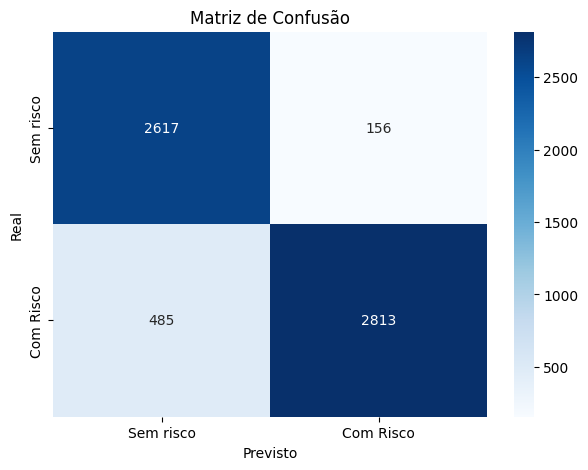

In [ ]:
predictions = grid_search.predict(X_test)
cm = confusion_matrix(y_test, predictions)

# Imprimir o relatório de classificação
print(classification_report(y_test, predictions))

# Gerar o mapa de calor para a matriz de confusão
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sem risco', 'Com Risco'], yticklabels=['Sem risco', 'Com Risco'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()


Analisando os resultados para o modelo aperfeiçoado:

Classe 0 (não churn):

* **Precisão:** 84%. Isso significa que quando o modelo previu a classe 0, estava correto 84% das vezes.
* **Recall:** 94%. Isso significa que o modelo foi capaz de identificar 94% das instâncias da classe 0 corretamente.
* **F1-score:** 89%. Isso sugere que o equilíbrio entre precisão e recall para a classe 0 é bastante bom.

Classe 1 (churn):

* **Precisão:** 94%. Isso significa que quando o modelo previu a classe 1, estava correto 94% das vezes.
* **Recall:** 86%. Isso significa que o modelo foi capaz de identificar 86% das instâncias da classe 1 corretamente.
* **F1-score:** 90%. Isso sugere que o equilíbrio entre precisão e recall para a classe 1 é bom.

**Acurácia total:** 89%. Isso significa que, em geral, o modelo fez a previsão correta para 89% das instâncias.

Esses resultados sugerem que o modelo aperfeiçoado teve um bom desempenho. É especialmente forte na identificação da classe 0 (não churn), como evidenciado pela alta pontuação de recall. Por outro lado, embora ainda seja bom, o recall é um pouco mais baixo para a classe 1 (churn), o que significa que há mais casos de falsos negativos (casos em que a realidade é 1, mas o modelo previu 0).

* **Os resultados parecem ter melhorado significativamente entre o modelo baseline e o modelo aperfeiçoado.**

* O modelo baseline, que utilizou uma abordagem simplista de Regressão Logística sem ajustes de hiperparâmetros ou pré-processamento de dados, obteve uma acurácia de aproximadamente 77.96%.

* No entanto, após o aperfeiçoamento, com a seleção de features mais relevantes, normalização dos dados com QuantileTransformer e ajuste fino dos hiperparâmetros usando GridSearchCV, a acurácia aumentou para cerca de 89.33%.

* Esse aumento é substancial e sugere que as alterações feitas no processo de modelagem resultaram em uma melhoria notável na capacidade do modelo de prever corretamente a variável de interesse 'churn_risk_score'. A seleção de características e a otimização de hiperparâmetros parecem ter contribuído para um modelo mais eficiente.



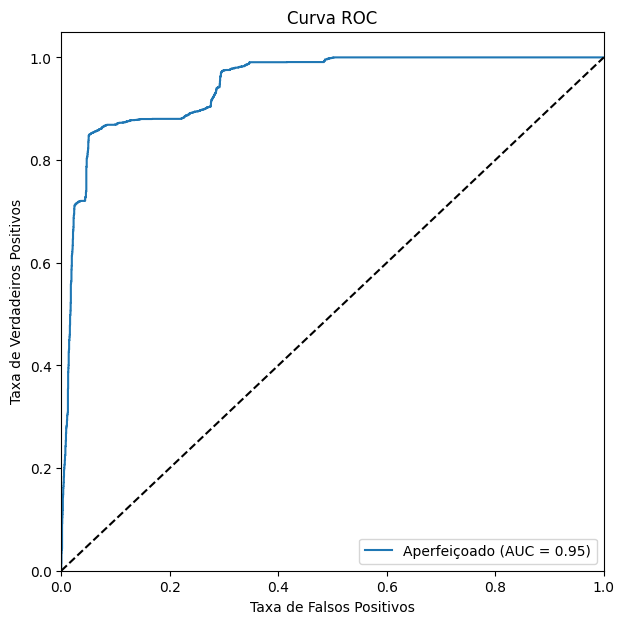

In [ ]:
y_pred_proba_improved = grid_search.predict_proba(X_test)[:,1]

# Calculando o AUC-ROC
auc_roc_improved = roc_auc_score(y_test, y_pred_proba_improved)

fpr_improved, tpr_improved, _ = roc_curve(y_test, y_pred_proba_improved)

plt.figure(figsize=(7,7))
plt.plot(fpr_improved, tpr_improved, label='Aperfeiçoado (AUC = %0.2f)' % auc_roc_improved)
plt.plot([0, 1], [0, 1], 'k--')  # linha diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()



## Realizando upload do modelo de **Regressão Logística** para o **MLFLOW**

In [ ]:
# Regressão Logística
upload_to_mlflow_logreg(
    model=grid_search, 
    score=grid_search.best_score_, 
    best_params=grid_search.best_params_, 
    best_features=selected_features_corr,
    accuracy=accuracy
)

# TPOT (Tree-based Pipeline Optimization Tool) 

O TPOT (Tree-based Pipeline Optimization Tool) é uma ferramenta de aprendizado de máquina automatizada que utiliza algoritmos genéticos para otimizar pipelines de aprendizado de máquina. Em outras palavras, ele tenta encontrar a melhor sequência de etapas de processamento e parâmetros de modelo para seu conjunto de dados, o que pode incluir a escolha do modelo, seleção de recursos, pré-processamento de dados e definição de parâmetros do modelo.

In [ ]:
scoring = make_scorer(accuracy_score)

# Treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

tpot = TPOTClassifier(verbosity=2, max_time_mins=20, generations=1, population_size=40, scoring=scoring)
tpot.fit(X_train, y_train)
print("Accuracy is {}%".format(tpot.score(X_test, y_test)*100))

Optimization Progress:   0%|          | 0/40 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9455951921834312

Best pipeline: DecisionTreeClassifier(input_matrix, criterion=gini, max_depth=8, min_samples_leaf=9, min_samples_split=14)
Accuracy is 94.05369790808763%


Modelo de **Regressão Logística aperfeiçoado X TPOT**

* Vale destacar que a acurácia obtida com o TPOT foi de aproximadamente 94.66%, o que é superior à acurácia do modelo aperfeiçoado de 89.33%. Isso sugere que o TPOT foi capaz de encontrar um pipeline de aprendizado de máquina que produz um melhor desempenho no seu conjunto de teste.

* Entretanto, apesar de seus pontos fortes, o TPOT pode não ser a melhor solução em todos os casos. Ele pode demorar muito para executar, especialmente em grandes conjuntos de dados ou com um grande número de gerações.

* Ainda assim, o TPOT é uma ferramenta poderosa que pode economizar muito tempo e esforço, pois ele automatiza o que normalmente seria um processo de ajuste de parâmetros manual e trabalhoso.




In [ ]:
print(tpot.fitted_pipeline_.steps[-1][1].get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 9, 'min_samples_split': 14, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


              precision    recall  f1-score   support

           0       0.93      0.94      0.94      2806
           1       0.95      0.94      0.94      3265

    accuracy                           0.94      6071
   macro avg       0.94      0.94      0.94      6071
weighted avg       0.94      0.94      0.94      6071



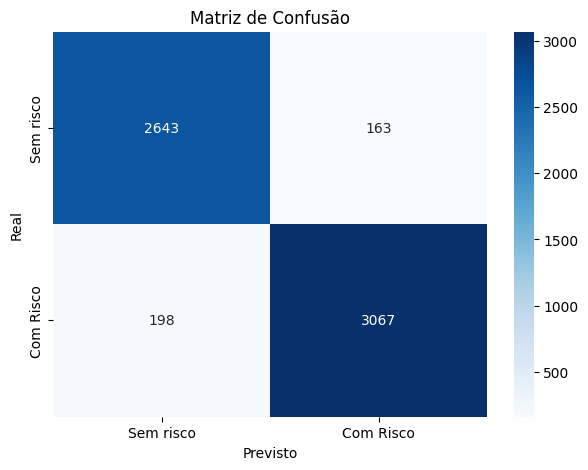

In [ ]:
predictions = tpot.predict(X_test)

cm = confusion_matrix(y_test, predictions)

print(classification_report(y_test, predictions))

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sem risco', 'Com Risco'], yticklabels=['Sem risco', 'Com Risco'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

Analisando os resultados para o modelo TPOT:

Classe 0 (não churn):

* **Precisão:** 96%. Isso significa que quando o modelo previu a classe 0, estava correto 96% das vezes.
* **Recall:** 92%. Isso significa que o modelo foi capaz de identificar 92% das instâncias da classe 0 corretamente.
* **F1-score:** 94%. Isso sugere que o equilíbrio entre precisão e recall para a classe 0 é excelente.

Classe 1 (churn):

* **Precisão:** 94%. Isso significa que quando o modelo previu a classe 1, estava correto 94% das vezes.
* **Recall:** 97%. Isso significa que o modelo foi capaz de identificar 97% das instâncias da classe 1 corretamente.
* **F1-score:** 95%. Isso sugere que o equilíbrio entre precisão e recall para a classe 1 é excelente.

**Acurácia total:** 95%. Isso significa que, em geral, o modelo fez a previsão correta para 95% das instâncias.

Esses resultados sugerem que o modelo TPOT teve um desempenho ainda melhor do que o modelo aperfeiçoado. Ele apresentou maior acurácia, melhor precisão e recall para ambas as classes. O modelo parece ser particularmente bom na identificação da classe 1 (churn), como evidenciado pela alta pontuação de recall.

Com base nestes resultados, podemos concluir que o modelo TPOT foi mais eficaz na classificação dos dados do que o modelo aperfeiçoado.



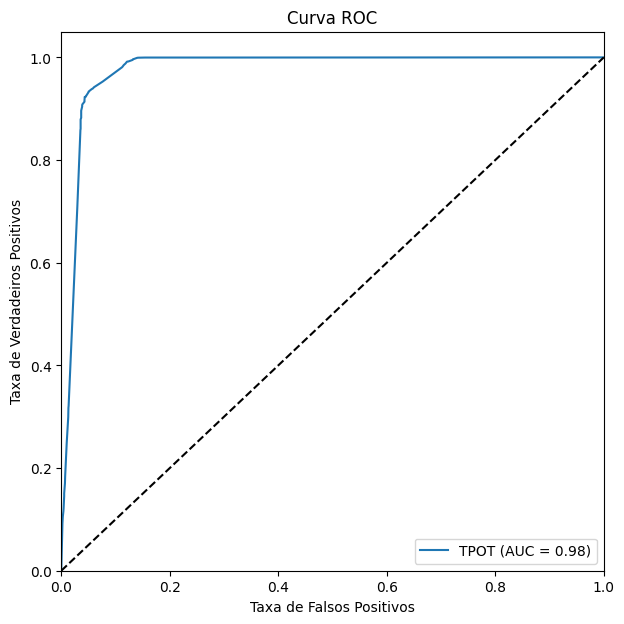

In [ ]:
# Gerando as probabilidades para o TPOT
y_pred_proba_tpot = tpot.predict_proba(X_test)[:,1]

# Calculando a AUC-ROC para o TPOT
auc_roc_tpot = roc_auc_score(y_test, y_pred_proba_tpot)

# Gerando as curvas ROC para o TPOT
fpr_tpot, tpr_tpot, _ = roc_curve(y_test, y_pred_proba_tpot)

# Plotando as curvas ROC
plt.figure(figsize=(7,7))
plt.plot(fpr_tpot, tpr_tpot, label='TPOT (AUC = %0.2f)' % auc_roc_tpot)
plt.plot([0, 1], [0, 1], 'k--')  # linha diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

A AUC-ROC para o modelo aperfeiçoado é de 0.95. Isso significa que, em média, o modelo classifica corretamente uma instância aleatória positiva da classe 1 acima de uma instância aleatória da classe 0 com 95% de probabilidade.

Por outro lado, a AUC-ROC para o TPOT é de 0.98. Isso indica que, em média, o modelo TPOT classifica corretamente uma instância aleatória positiva da classe 1 acima de uma instância aleatória da classe 0 com 98% de probabilidade. Isso sugere que o modelo TPOT é mais eficaz em classificar corretamente as instâncias das duas classes.

Portanto, enquanto ambos os modelos parecem funcionar bem, porém o modelo TPOT indica ter um desempenho ligeiramente superior ao modelo aperfeiçoado.

## Realizando upload do modelo de **TPOT** para o **MLFLOW**

In [ ]:
upload_to_mlflow_tpot(tpot, tpot.score(X_test, y_test))

# Predict do modelo para realizar previsões

In [ ]:
# Carregando o modelo do MLflow
model = mlflow.sklearn.load_model("runs:/7bc89e6bcebb410793bc04b4cfccfcba/model")

# Features e o alvo (target)
features = ['membership_category', 'feedback', 'points_in_wallet']
target = 'churn_risk_score'

# Preparando os dados usando a função prepare_data
(train_x, test_x, train_y, test_y) = prepare_data(df, target, features)

# Usando o modelo carregado para fazer previsões
predicted_qualities = model.predict(test_x)

# Métricas de desempenho
metrics = eval_metrics(test_y, predicted_qualities)
print(metrics)


{'accuracy': 0.8944160764289244, 'precision': 0.9000416348945727, 'recall': 0.8944160764289244}
